In [1]:
import os
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

2025-04-14 18:23:09.614987: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-14 18:23:12.630593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.10.4 anndata==0.11.3 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.3 scikit-learn==1.4.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.12


In [2]:
ROOT_DIR = '/work/hdd/bbjr/mallina1/data/human_cellariumgpt_v2/assay_conversion'

# INP_DIR = max((d for d in os.listdir(ROOT_DIR) if os.path.isdir(os.path.join(ROOT_DIR, d))), key=lambda x: os.path.getctime(os.path.join(ROOT_DIR, x)))
# print(INP_DIR)

# INP_DIR = '2025_04_03_17_40_convert_to_10x_Chromium_v2_A_ngenes4096_counts500_umis500_20000'
# INP_DIR = '2025_04_03_17_37_convert_to_10x_Chromium_v2_A_ngenes4096_counts2001_umis500_20000'
INP_DIR = '2025_04_13_23_36_convert_to_10x_Chromium_v3_ngenes4096_counts500_umis0_200000_remove_ig_False'
INP_DIR = '2025_04_14_05_20_convert_to_10x_Chromium_v2_A_ngenes4096_counts500_umis0_200000_remove_ig_False'

# original input assays
original_methods = ['10x Chromium (v2) A', '10x Chromium (v2) B', '10x Chromium (v3)',
                    'Drop-seq', 'Seq-Well', 'inDrops']
# original_methods = ['inDrops', '10x Chromium (v3)', 'Seq-Well', '10x Chromium (v2) A', 
#                     'Drop-seq', '10x Chromium (v2) B']

# target_assay = '10x Chromium (v3)'
target_assay = original_methods[2]

In [3]:
original_adata = sc.read_h5ad(os.path.join(ROOT_DIR, INP_DIR, 'original.h5ad'))
converted_adata = sc.read_h5ad(os.path.join(ROOT_DIR, INP_DIR, 'converted.h5ad'))
converted_means_adata = sc.read_h5ad(os.path.join(ROOT_DIR, INP_DIR, 'converted_means.h5ad'))

In [4]:
original_adata

AnnData object with n_obs × n_vars = 26561 × 4096
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'assay', 'assay_ontology_term_id', 'suspension_type', 'total_mrna_umis'
    var: 'gene_symbols', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'CellType_colors', 'Method_colors', 'hvg'
    obsm: 'X_harmony'

In [5]:
converted_means_adata

AnnData object with n_obs × n_vars = 26561 × 4096
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'assay', 'assay_ontology_term_id', 'suspension_type', 'total_mrna_umis'
    var: 'gene_symbols', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'CellType_colors', 'Method_colors', 'hvg'
    obsm: 'X_harmony'

In [6]:
# cell_type = 'B cell'
# cell_type = 'Cytotoxic T cell'
ct_original = original_adata.copy()
ct_converted = converted_adata.copy()
ct_converted_means = converted_means_adata.copy()

In [7]:
ct_combined = ct_original.concatenate(ct_converted)

/tmp/ipykernel_1339617/649068035.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ct_combined = ct_original.concatenate(ct_converted)


In [ ]:
ct_combined.obs

,NAME,nGene,nUMI,percent.mito,Cluster,CellType,Experiment,Method,assay,assay_ontology_term_id,suspension_type,total_mrna_umis,batch
253-0,pbmc1_10x_v2_A_AAAGATGCAAAGTCAA,851,2177,0.0381258612769867,5,CD14+ monocyte,pbmc1,10x Chromium (v2) A,10x 3' v2,EFO:0009899,cell,2177,0
254-0,pbmc1_10x_v2_A_AAAGCAAGTAGGAGTC,1078,3065,0.0417618270799347,5,CD14+ monocyte,pbmc1,10x Chromium (v2) A,10x 3' v2,EFO:0009899,cell,3065,0
255-0,pbmc1_10x_v2_A_AAAGCAATCGGTTCGG,538,977,0.0992835209825998,4,CD14+ monocyte,pbmc1,10x Chromium (v2) A,10x 3' v2,EFO:0009899,cell,977,0
256-0,pbmc1_10x_v2_A_AAAGTAGTCATTTGGG,1544,4933,0.0427731603486722,5,CD14+ monocyte,pbmc1,10x Chromium (v2) A,10x 3' v2,EFO:0009899,cell,4933,0
257-0,pbmc1_10x_v2_A_AAAGTAGTCCGAGCCA,632,1487,0.0477471418964358,4,CD14+ monocyte,pbmc1,10x Chromium (v2) A,10x 3' v2,EFO:0009899,cell,1487,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30490-1,pbmc2_inDrops_1_TAGTCTCT.GAGCCTTA.ATCCGCTA,453,717,0.097629009762901,11,Plasmacytoid dendritic cell,pbmc2,inDrops,inDrop,EFO:0008780,cell,717,1
30491-1,pbmc2_inDrops_1_TCCAGAAG.TTATGCGA.TAAGACGG,592,938,0.035181236673774,11,Plasmacytoid dendritic cell,pbmc2,inDrops,inDrop,EFO:0008780,cell,938,1
30492-1,pbmc2_inDrops_1_TGAATCCT.GAGCCTTA.CCCAAGCA,406,662,0.138972809667674,11,Plasmacytoid dendritic cell,pbmc2,inDrops,inDrop,EFO:0008780,cell,662,1
30493-1,pbmc2_inDrops_1_TGAATCCT.TTATGCGA.CATCTCCC,1001,2066,0.0556631171345595,11,Plasmacytoid dendritic cell,pbmc2,inDrops,inDrop,EFO:0008780,cell,2066,1


In [9]:
# sc.pp.filter_cells(ct_original, min_genes=200)
# sc.pp.filter_genes(ct_original, min_cells=3)

# this is needed to do regress_out and scale
ct_original.var["mt"] = ct_original.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    ct_original, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

sc.pp.highly_variable_genes(ct_original, flavor='seurat_v3', n_top_genes=2000)
sc.pp.normalize_total(ct_original, target_sum=1e4)
sc.pp.log1p(ct_original)
# sc.pp.highly_variable_genes(ct_original, min_mean=0.0125, max_mean=3, min_disp=0.5)

ct_original.raw = ct_original.copy()
ct_original = ct_original[:, ct_original.var.highly_variable]

sc.pp.regress_out(ct_original, ["total_counts", "pct_counts_mt"])
sc.pp.scale(ct_original, max_value=10)

sc.tl.pca(ct_original, svd_solver="arpack")
sc.pp.neighbors(ct_original, n_neighbors=10, n_pcs=10)

# sc.tl.leiden(ct_original, use_weights=True)
sc.tl.leiden(
    ct_original,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

sc.tl.paga(ct_original)
sc.pl.paga(ct_original, plot=False)

sc.tl.umap(ct_original, init_pos='paga')

extracting highly variable genes


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/u/mallina1/envs/torch_jax2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:22)
computing PCA
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)
running Leiden clustering
    finished: found 28 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)


In [10]:
# sc.pp.filter_cells(ct_converted, min_genes=200)
# sc.pp.filter_genes(ct_converted, min_cells=3)

# this is needed to do regress_out and scale
ct_converted.var["mt"] = ct_converted.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    ct_converted, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

sc.pp.highly_variable_genes(ct_converted, flavor='seurat_v3', n_top_genes=2000)
sc.pp.normalize_total(ct_converted, target_sum=1e4)
sc.pp.log1p(ct_converted)
# sc.pp.highly_variable_genes(ct_converted, min_mean=0.0125, max_mean=3, min_disp=0.5)

ct_converted.raw = ct_converted.copy()
ct_converted = ct_converted[:, ct_converted.var.highly_variable]

sc.pp.regress_out(ct_converted, ["total_counts", "pct_counts_mt"])
sc.pp.scale(ct_converted, max_value=10)

sc.tl.pca(ct_converted, svd_solver="arpack")
sc.pp.neighbors(ct_converted, n_neighbors=10, n_pcs=10)

# sc.tl.leiden(ct_converted, use_weights=True)
sc.tl.leiden(
    ct_converted,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

sc.tl.paga(ct_converted)
sc.pl.paga(ct_converted, plot=False)

sc.tl.umap(ct_converted, init_pos='paga')

extracting highly variable genes


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/u/mallina1/envs/torch_jax2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:21)
computing PCA
    with n_comps=50
    finished (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)


In [11]:
# sc.pp.filter_cells(ct_converted_means, min_genes=200)
# sc.pp.filter_genes(ct_converted_means, min_cells=3)

# this is needed to do regress_out and scale
ct_converted_means.var["mt"] = ct_converted_means.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    ct_converted_means, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

sc.pp.highly_variable_genes(ct_converted_means, flavor='seurat_v3', n_top_genes=2000)
sc.pp.normalize_total(ct_converted_means, target_sum=1e4)
sc.pp.log1p(ct_converted_means)
# sc.pp.highly_variable_genes(ct_converted_means, min_mean=0.0125, max_mean=3, min_disp=0.5)

ct_converted_means.raw = ct_converted_means.copy()
ct_converted_means = ct_converted_means[:, ct_converted_means.var.highly_variable]

sc.pp.regress_out(ct_converted_means, ["total_counts", "pct_counts_mt"])
sc.pp.scale(ct_converted_means, max_value=10)

sc.tl.pca(ct_converted_means, svd_solver="arpack")
sc.pp.neighbors(ct_converted_means, n_neighbors=10, n_pcs=10)

# sc.tl.leiden(ct_converted_means, use_weights=True)
sc.tl.leiden(
    ct_converted_means,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

sc.tl.paga(ct_converted_means)
sc.pl.paga(ct_converted_means, plot=False)

sc.tl.umap(ct_converted_means, init_pos='paga')

extracting highly variable genes


/u/mallina1/envs/torch_jax2/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts', 'pct_counts_mt']


/u/mallina1/envs/torch_jax2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    sparse input is densified and may lead to high memory use
    finished (0:00:21)
computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Leiden clustering
    finished: found 40 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:14)


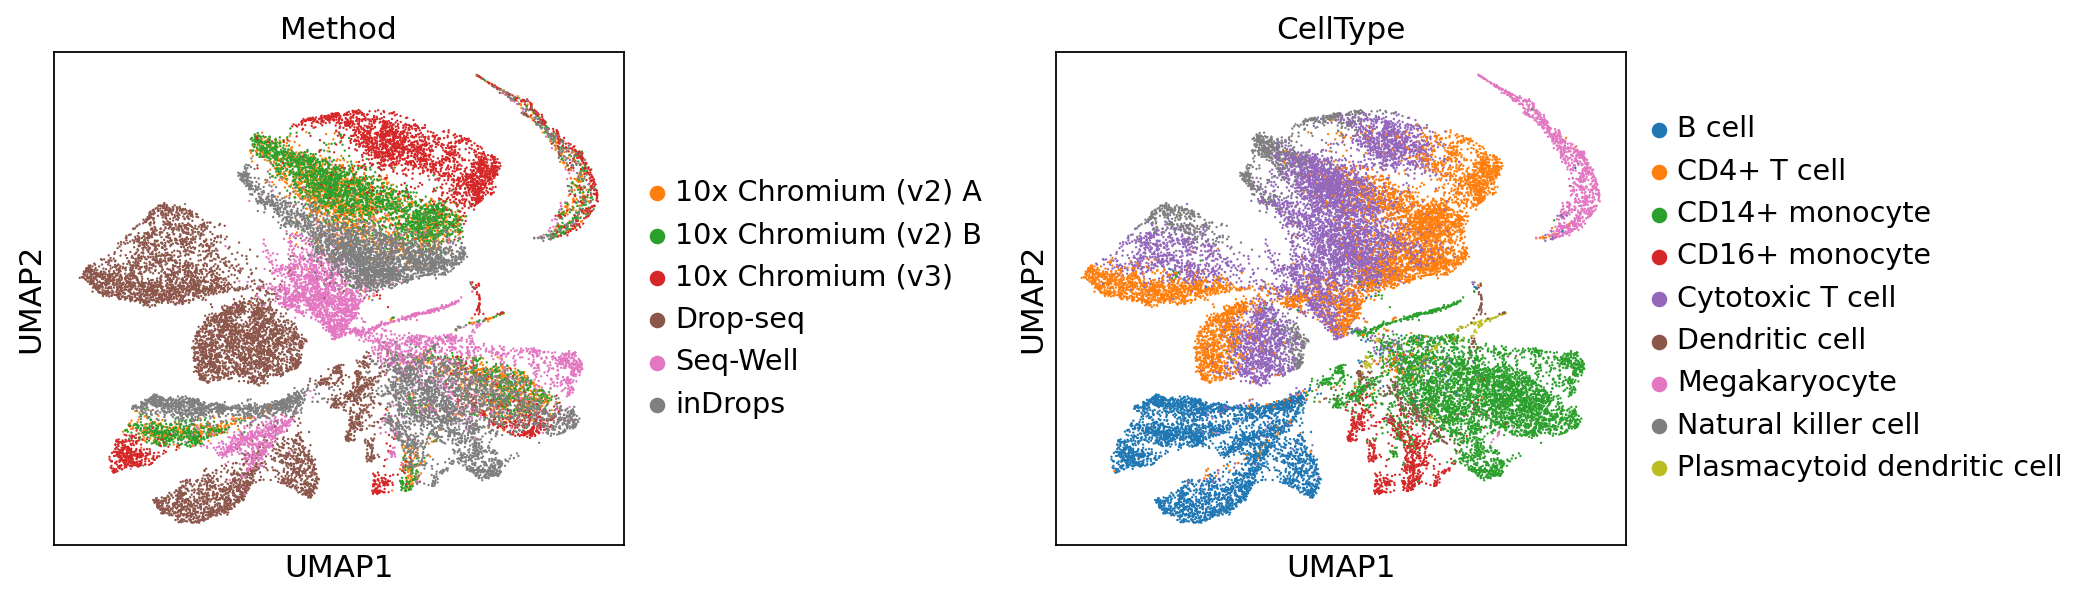

In [12]:
sc.pl.umap(ct_original, color=["Method", "CellType"], wspace=0.6)

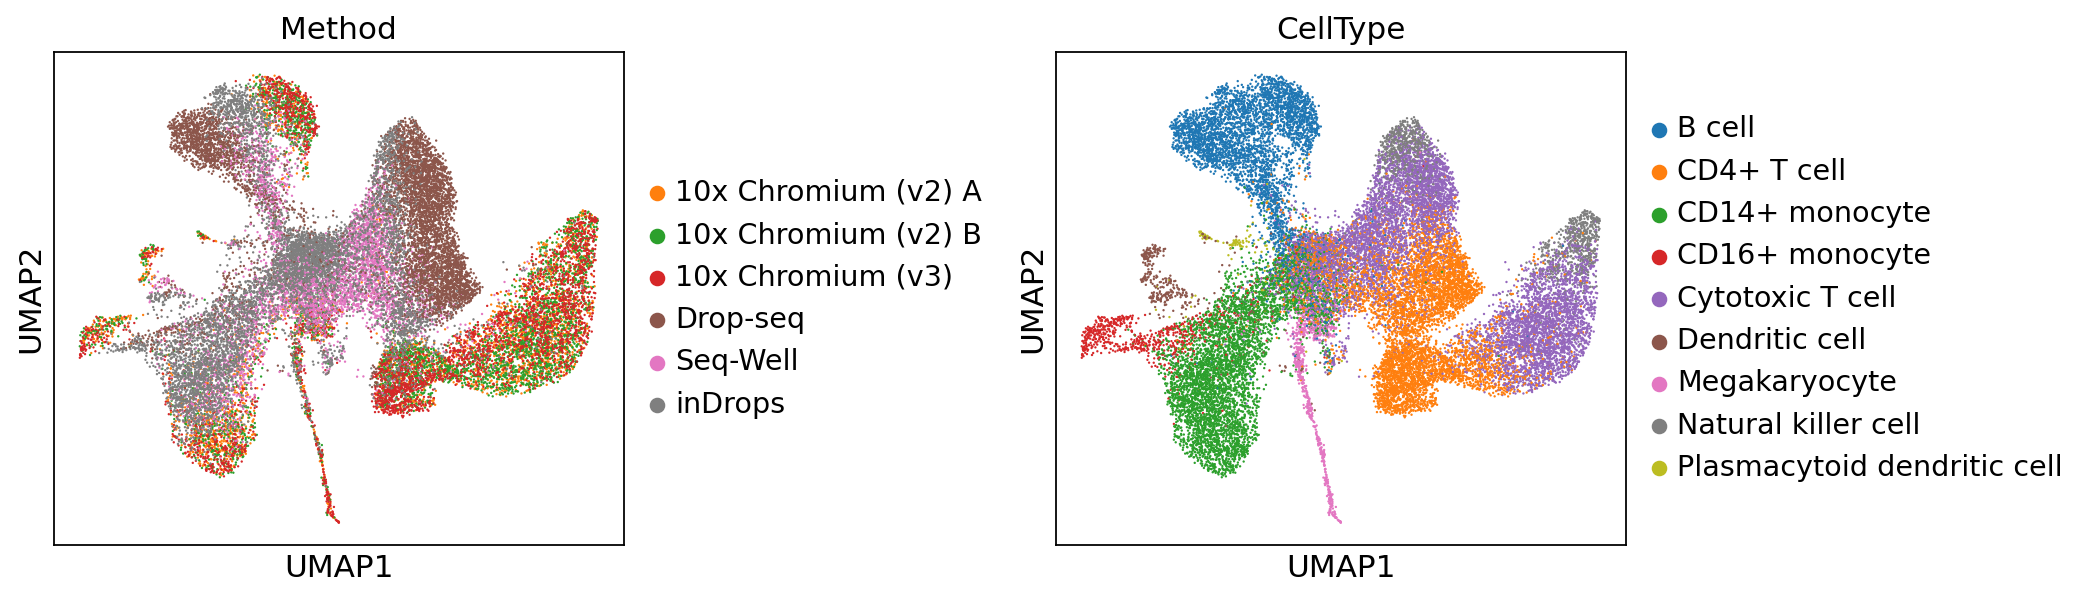

In [13]:
sc.pl.umap(ct_converted, color=["Method", "CellType"], wspace=0.6)

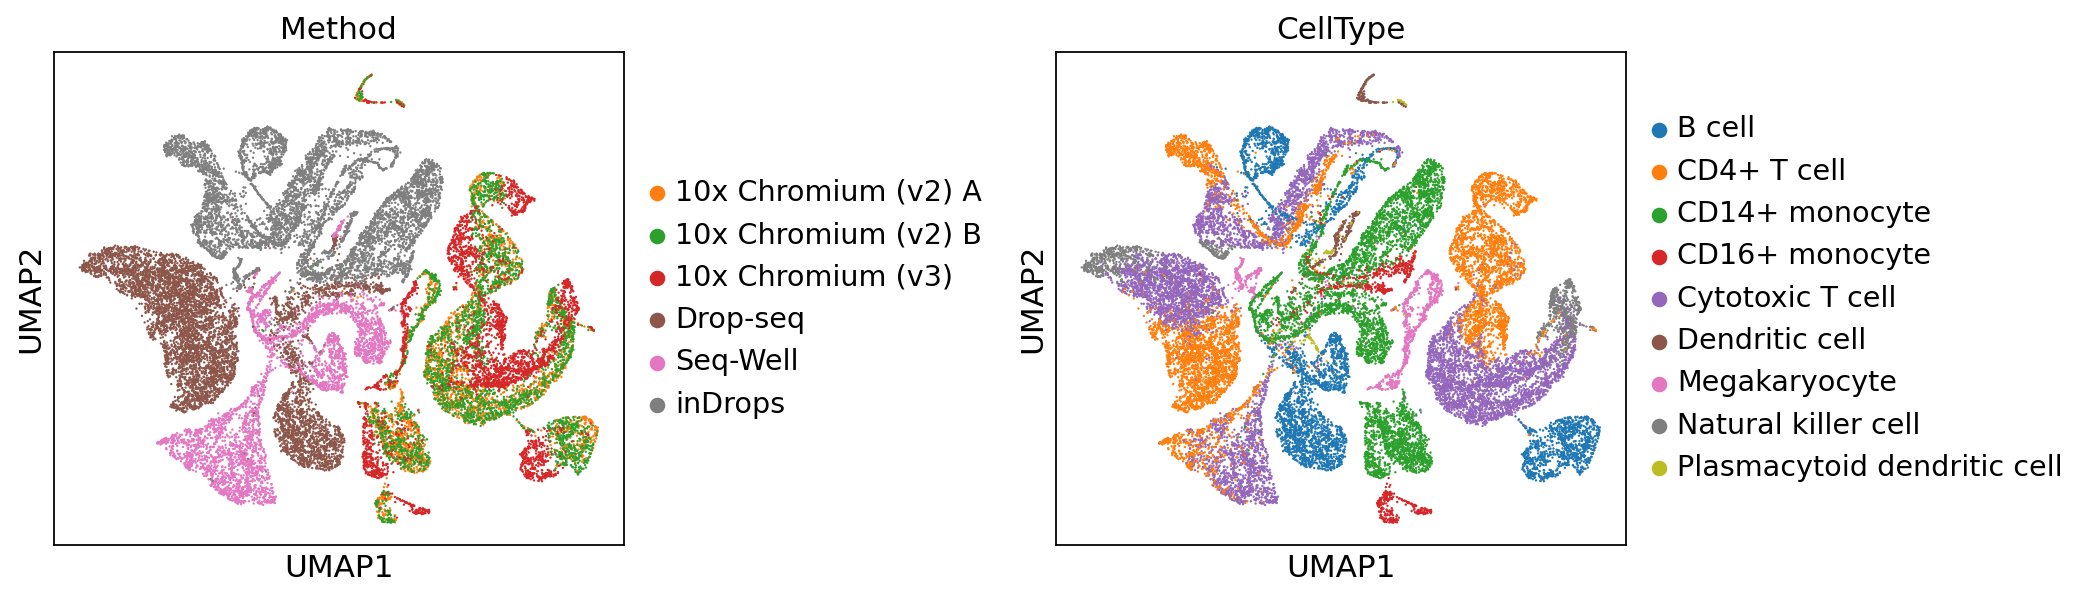

In [ ]:
sc.pl.umap(ct_converted_means, color=["Method", "CellType"], wspace=0.6)

In [15]:
# sc.pp.filter_cells(ct_combined, min_genes=200)
# sc.pp.filter_genes(ct_original, min_cells=3)

# this is needed to do regress_out and scale
ct_combined.var["mt"] = ct_combined.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    ct_combined, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

sc.pp.highly_variable_genes(ct_combined, flavor='seurat_v3', n_top_genes=2000)
sc.pp.normalize_total(ct_combined, target_sum=1e4)
sc.pp.log1p(ct_combined)
# sc.pp.highly_variable_genes(ct_combined, min_mean=0.0125, max_mean=3, min_disp=0.5)

ct_combined.raw = ct_combined.copy()
ct_combined = ct_combined[:, ct_combined.var.highly_variable]

sc.pp.regress_out(ct_combined, ["total_counts", "pct_counts_mt"])
sc.pp.scale(ct_combined, max_value=10)

sc.tl.pca(ct_combined, svd_solver="arpack")
sc.pp.neighbors(ct_combined, n_neighbors=10, n_pcs=10)

# sc.tl.leiden(ct_combined, use_weights=True)
sc.tl.leiden(
    ct_combined,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

sc.tl.paga(ct_combined)
sc.pl.paga(ct_combined, plot=False)

sc.tl.umap(ct_combined, init_pos='paga')

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/u/mallina1/envs/torch_jax2/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


    finished (0:00:39)
computing PCA
    with n_comps=50
    finished (0:00:18)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 31 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:02)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:29)


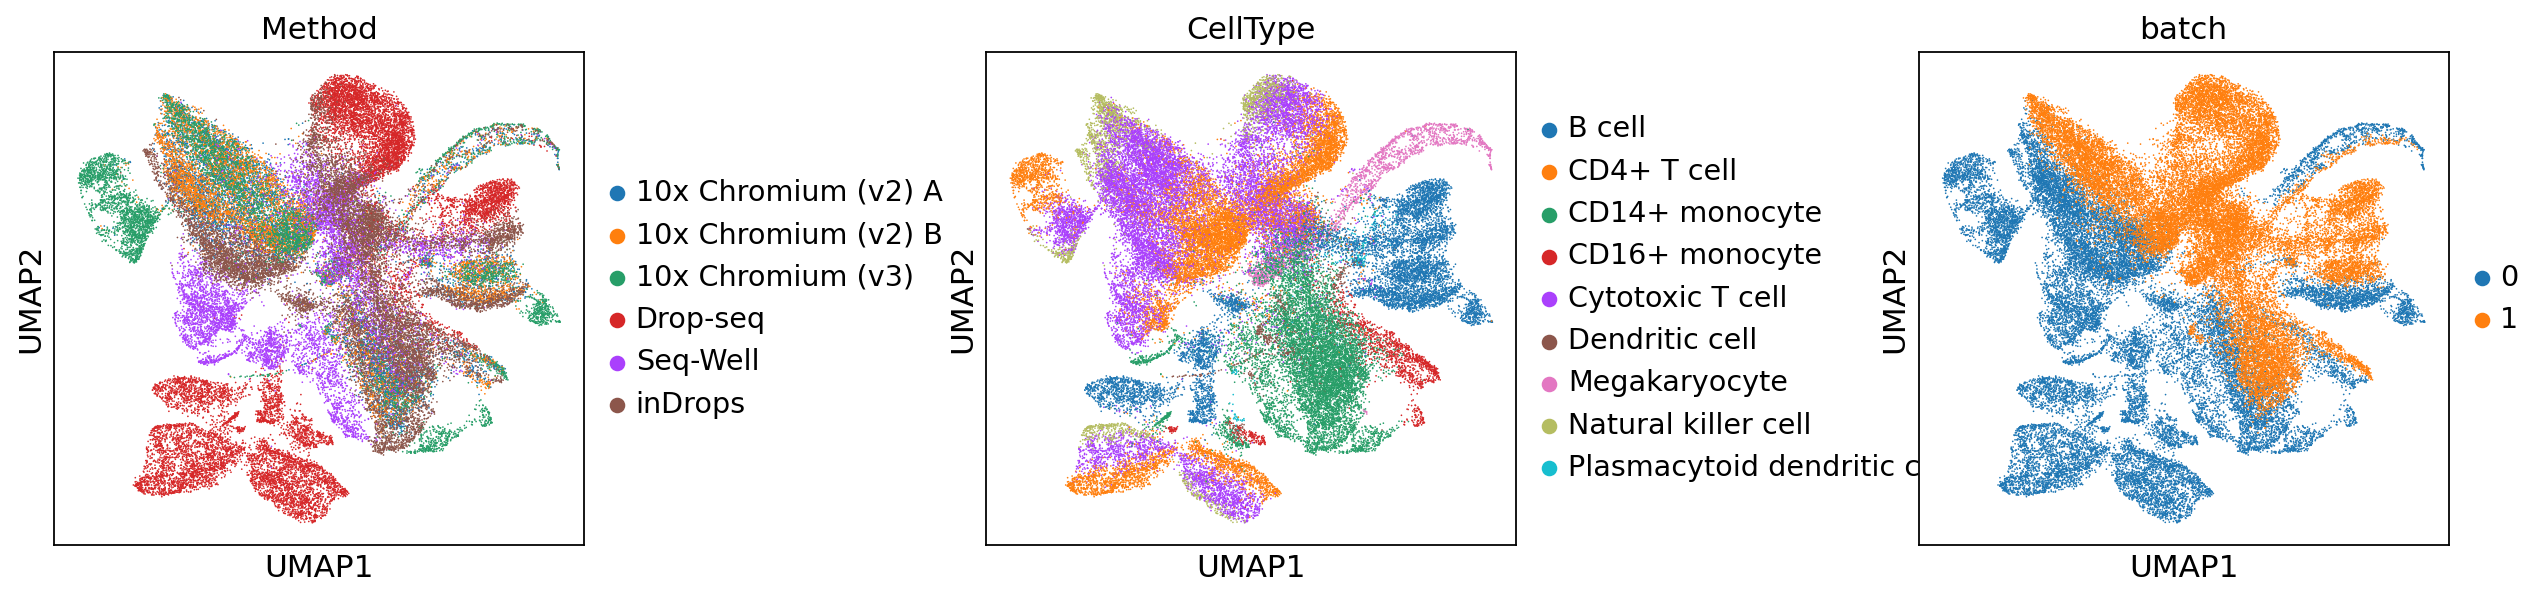

In [16]:
sc.pl.umap(ct_combined, color=["Method", "CellType", "batch"], wspace=0.6)